In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lifetimes
!pip install lime

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import time as tm

import lifetimes as lf

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from pandas.api.types import CategoricalDtype
import plotly.express as px
from matplotlib.pyplot import figure
import plotnine as pn
import lime
from lime import lime_tabular

import warnings
warnings.filterwarnings('ignore') #this line is used to ignore the warnings

pd.set_option("display.precision",2)    #to set the precision of the float values
np.set_printoptions(precision=2, suppress=True) #to supress scientific notation
pd.options.display.float_format = '{:,.3f}'.format #to supress scientific notation

In [ ]:

df0 = pd.read_parquet('/content/drive/MyDrive/transactions_dataset.parquet')


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
df0.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.443,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.394,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.766,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.599,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,"1,093.374",3,by phone,7051


In [ ]:
df0['branch_id'].nunique()

582

In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date_order     object 
 1   date_invoice   object 
 2   product_id     int64  
 3   client_id      int64  
 4   sales_net      float64
 5   quantity       int64  
 6   order_channel  object 
 7   branch_id      int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.8+ GB


In [ ]:
#here we will optimise the dataset and also create some new features. Although these features will not be used for now

def extract_dates(df):
    df['data_order_year']=df['date_order'].dt.year
    df['data_order_month']=df['date_order'].dt.month_name()
    df['data_order_dayofmonth']=df['date_order'].dt.day
    df['data_order_dayofweek']=df['date_order'].dt.day_name()
    df['month_year'] = df['date_order'].dt.strftime('%Y-%m')
    return df

def data_optimize(df):
    df.product_id= df.product_id.astype(np.int32)
    df.client_id= df.client_id.astype(np.int32)
    df.quantity= df.quantity.astype(np.int32)
    df.branch_id= df.branch_id.astype(np.int16)
    df.sales_net=df.sales_net.astype(np.float32)
    df['date_order'] =  pd.to_datetime(df['date_order'], format='%Y-%m-%d')
    df['date_invoice'] =  pd.to_datetime(df['date_invoice'], format='%Y-%m-%d')
    df.order_channel= df.order_channel.astype('category')
    return df

df=(df0
.pipe(data_optimize)
.pipe(extract_dates))

df[['data_order_month', 'data_order_year', 'data_order_dayofweek', 'data_order_dayofmonth','month_year']]=df[['data_order_month', 'data_order_year', 'data_order_dayofweek', 'data_order_dayofmonth','month_year']].astype('category')


In [ ]:
df0.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,data_order_year,data_order_month,data_order_dayofmonth,data_order_dayofweek,month_year
0,2017-09-25,2017-09-25,2376333,188502,155.443,3,online,2732,2017,September,25,Monday,2017-09
1,2017-09-25,2017-09-25,2520527,835089,16.394,3,at the store,10279,2017,September,25,Monday,2017-09
2,2017-09-25,2017-09-25,2536756,1977896,365.766,21,online,6184,2017,September,25,Monday,2017-09
3,2017-09-25,2017-09-25,3028673,598816,8.599,201,at the store,4200,2017,September,25,Monday,2017-09
4,2017-09-25,2017-09-25,203377,2086861,"1,093.374",3,by phone,7051,2017,September,25,Monday,2017-09


In [ ]:
daily_quantity = df0[['date_order', 'quantity']].groupby(['date_order']).sum()
daily_quantity.head()

,quantity
date_order,
2017-09-22,570
2017-09-23,9544
2017-09-24,22644
2017-09-25,10714195
2017-09-26,11371242


In [ ]:
daily_quantity = daily_quantity.sort_values('date_order')
daily_quantity.head()

,quantity
date_order,
2017-09-22,570
2017-09-23,9544
2017-09-24,22644
2017-09-25,10714195
2017-09-26,11371242


In [ ]:
daily_quantity['date_order'] = daily_quantity.index

daily_quantity.head()

,quantity,date_order
date_order,,
2017-09-22,570,2017-09-22
2017-09-23,9544,2017-09-23
2017-09-24,22644,2017-09-24
2017-09-25,10714195,2017-09-25
2017-09-26,11371242,2017-09-26


In [ ]:
daily_quantity.reset_index

<bound method DataFrame.reset_index of             quantity date_order
date_order                     
2017-09-22       570 2017-09-22
2017-09-23      9544 2017-09-23
2017-09-24     22644 2017-09-24
2017-09-25  10714195 2017-09-25
2017-09-26  11371242 2017-09-26
...              ...        ...
2019-09-18   5881484 2019-09-18
2019-09-19   5021328 2019-09-19
2019-09-20   3562304 2019-09-20
2019-09-21     27032 2019-09-21
2019-09-22      3781 2019-09-22

[731 rows x 2 columns]>

In [ ]:
daily_quantity.head()

,quantity,date_order
date_order,,
2017-09-22,570,2017-09-22
2017-09-23,9544,2017-09-23
2017-09-24,22644,2017-09-24
2017-09-25,10714195,2017-09-25
2017-09-26,11371242,2017-09-26


Text(0.5, 1.0, 'Daily Total quantity')

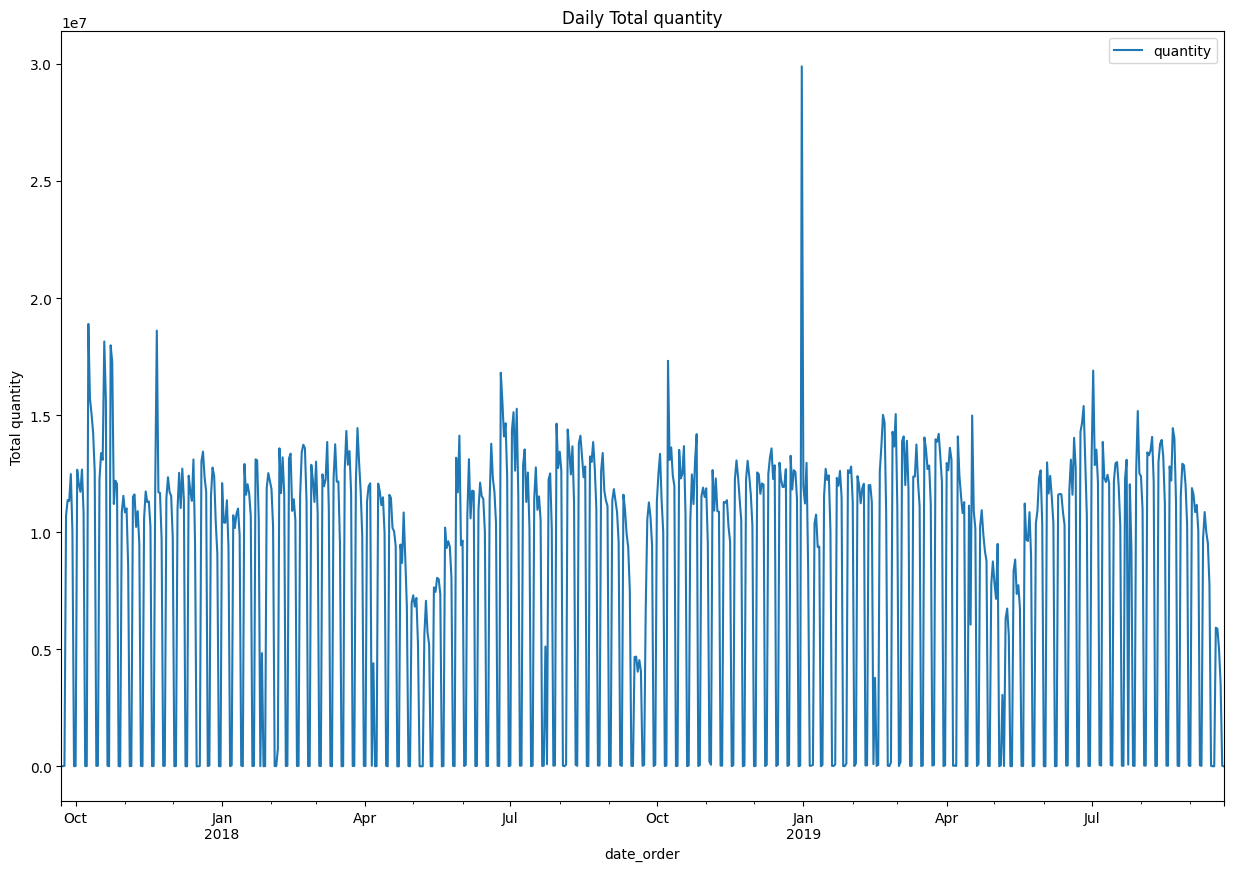

In [ ]:
daily_quantity.plot(x="date_order", y="quantity",kind='line',figsize=(15,10))
plt.ylabel('Total quantity')
plt.title('Daily Total quantity')

We repeat the same procedure for weekly sales, to detect any other special pattern

In [ ]:
#We need to create a weekly dataset

daily_quantity.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2017-09-22 to 2019-09-22
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   quantity    731 non-null    int32         
 1   date_order  731 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(1)
memory usage: 14.3 KB


In [ ]:
weekly_quantity = daily_quantity.resample('W-Mon', on='date_order').sum().reset_index()

Text(0.5, 1.0, 'Weekly Total quantity')

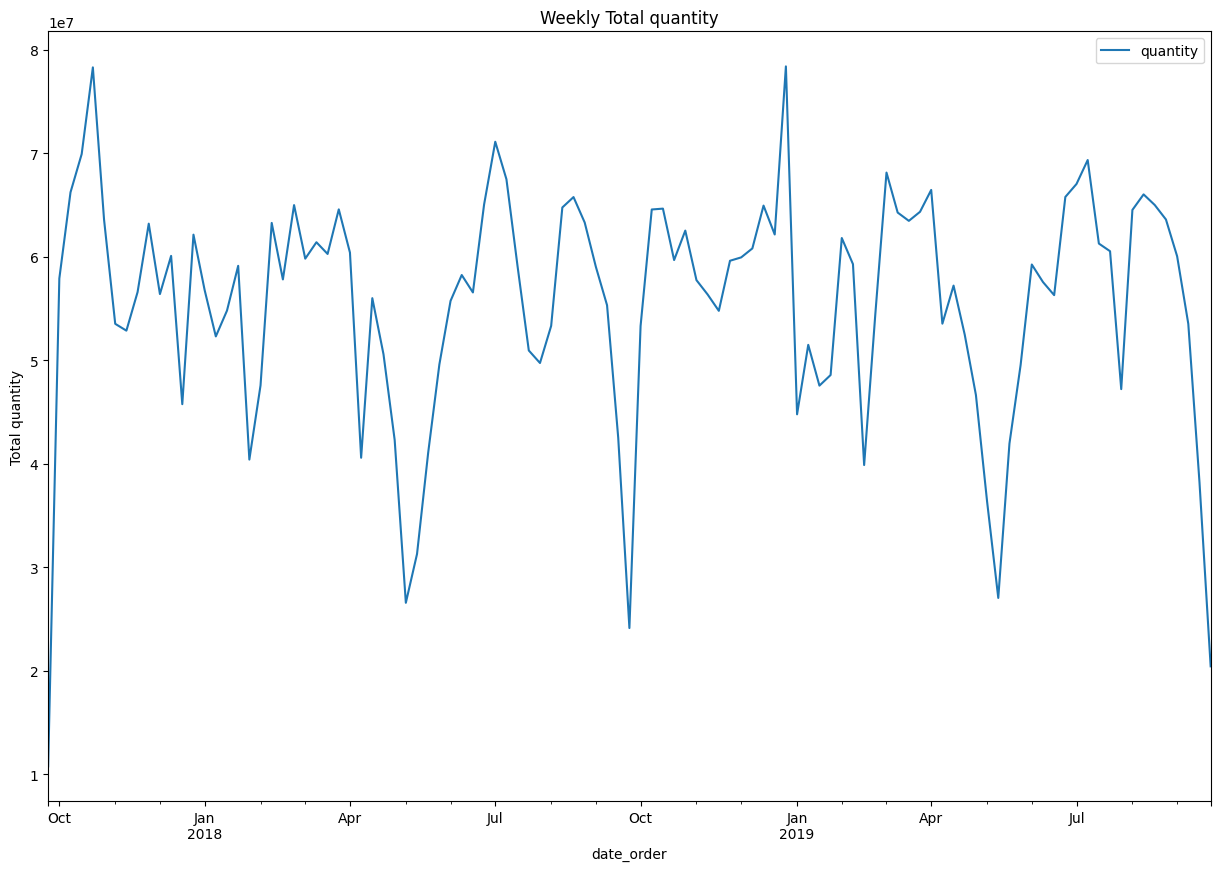

In [ ]:
weekly_quantity.plot(x="date_order", y="quantity",kind='line',figsize=(15,10))
plt.ylabel('Total quantity')
plt.title('Weekly Total quantity')

# Machine Learning Model Building



In [ ]:
df0.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,data_order_year,data_order_month,data_order_dayofmonth,data_order_dayofweek,month_year
0,2017-09-25,2017-09-25,2376333,188502,155.443,3,online,2732,2017,September,25,Monday,2017-09
1,2017-09-25,2017-09-25,2520527,835089,16.394,3,at the store,10279,2017,September,25,Monday,2017-09
2,2017-09-25,2017-09-25,2536756,1977896,365.766,21,online,6184,2017,September,25,Monday,2017-09
3,2017-09-25,2017-09-25,3028673,598816,8.599,201,at the store,4200,2017,September,25,Monday,2017-09
4,2017-09-25,2017-09-25,203377,2086861,"1,093.374",3,by phone,7051,2017,September,25,Monday,2017-09


In [ ]:
!pip install category_encoders


In [ ]:
#Transform product_id, client_id and branch_id into categorical columns

df0['product_id'] = df0['product_id'].astype('category')
df0['client_id'] = df0['client_id'].astype('category')
df0['branch_id'] = df0['branch_id'].astype('category')

In [ ]:

from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

X = df0.drop('quantity', axis=1)
y = df0['quantity']


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

encoder = TargetEncoder()

encoded_columns = ['product_id', 'client_id', 'branch_id', 'order_channel']


for col in encoded_columns:
  X_train[col] = encoder.fit_transform(X_train[col],y_train)
  X_test[col] = encoder.transform(X_test[col])

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

In [ ]:
#drop datetime columns from x and y

X_train = X_train.drop(['date_order', 'date_invoice', 'data_order_year','data_order_dayofmonth', 'data_order_dayofweek', 'month_year'], axis=1)
X_test = X_test.drop(['date_order', 'date_invoice', 'data_order_year','data_order_dayofmonth', 'data_order_dayofweek', 'month_year'], axis=1)

In [ ]:
X_train.head()

In [ ]:
#import xgboost regresor

from xgboost import XGBRegressor

#Initialise base model

xgb_model = XGBRegressor(enable_categorical = True)

#Fit the model
xgb_model.fit(X_train, y_train)

#test the model

y_pred = xgb_model.predict(X_test)


In [ ]:
#model evaluatioon

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# calculate MAE between expected and predicted values for december

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

#calculate MAPE between expected and predicted values for december

mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAPE: %.3f' % mape)





```
# This is formatted as code


#now time for the hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV

#define the hyperparameter grip for xgboost regressor

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0]
}
# create a randomized search cross-validation object with 5-fold cross-validation
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=20, cv=5,verbose=0)

# fit the randomized search cross-validation object to the training data
random_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = random_search.best_params_
print(best_params)

# predict with our best parameters model

y_pred = random_search.predict(X_test)



#model evaluatioon

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error

# calculate MAE between expected and predicted values for december

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

#calculate MAPE between expected and predicted values for december

mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAPE: %.3f' % mape)

# calculate RMSE between expected and predicted values
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % rmse)

# calculate MSE between expected and predicted values

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)

```